In [19]:
from pytorch_lightning.callbacks import ModelCheckpoint
# from comet_ml import Experiment

import pytorch_lightning as pl
import os
from plotting import *
from torch.nn import functional as FF
from lit_nf import LitNF
from jetnet_dataloader import JetNetDataloader
from helpers import mass
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import os
from scipy import stats
import datetime
import pandas as pd
import traceback
from jetnet.evaluation import w1p, w1efp, w1m, cov_mmd,fpnd
import time
import matplotlib.pyplot as plt
import numpy as np

In [21]:
import torchinfo

class plotting_paper():
    '''This is a class that takes care of  plotting steps in the script,
        It is initialized with the following arguments:
        true=the simulated data, note that it needs to be scaled
        gen= Generated data , needs to be scaled
        step=The current step of the training, this is need for tensorboard
        model=the model that is trained, a bit of an overkill as it is only used to access the losses
        config=the config used for training
        logger=The logger used for tensorboard logging'''
    def __init__(self,true,gen,config,p,model=None,logger=None,weight=1):
        self.config=model.config
        self.n_dim=self.config["n_dim"]
        self.gen=gen
        self.test_set=true

        self.model=model
        self.p=p

        self.weight=weight
        if logger is not None:
            self.summary=logger
    def plot_mass_only(self,m,m_t,bins=15):
        fig,ax=plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]},figsize=(6,8))
        a=min(np.quantile(m_t,0.001),np.quantile(m,0.001))
        b=max(np.quantile(m_t,0.999),np.quantile(m,0.999))
        a=np.quantile(m_t,0.001)
        b=np.quantile(m_t,0.999)
        h=hist.Hist(hist.axis.Regular(bins,a,b))
        h2=hist.Hist(hist.axis.Regular(bins,a,b))
        bins = h.axes[0].edges
        h.fill(m)#,weight=1/self.weight)
        h2.fill(m_t)
            
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )

        main_ax_artists, sublot_ax_arists = h.plot_ratio(
            h2,
            ax_dict={"main_ax":ax[0],"ratio_ax":ax[1]},
            rp_ylabel=r"Ratio",
            rp_num_label="Generated",
            rp_denom_label="Ground Truth",
            rp_uncert_draw_type="line",  # line or bar
        )
        ax[0].set_xlabel("")
#                 if quantile and v=="m" and plot_vline:
#                     ax[0,k].hist(m[m_t<np.quantile(m_t,0.1)],histtype='step',bins=bins,alpha=1,color="red",label="10% quantile gen",hatch="/")
#                     ax[0,k].vlines(np.quantile(m_t,0.1),0,np.max(h[:]),color="red",label='10% quantile train')

        ax[1].set_ylim(0.25,2)
        ax[0].set_xlim(a,b)
        ax[1].set_xlabel("$m_T$",fontsize=22)
        ax[1].set_xlim(a,b)
        ax[0].set_ylabel("Counts" ,fontsize=18)
        ax[1].set_ylabel("Ratio",fontsize=18)
        # plt.savefig("{}_mass".format(self.p))
        plt.show()

    def plot_marginals(self,ith=None,title=None,save=None):
        #This plots the marginal distribution for simulation and generation
        #Note that this is the data the model sees during training as input to model in the NF
        #This is the distribution of one of [eta,phi,pt] of one particle of the n particles per jet: for example the pt of the 3rd particle
        #if save, the histograms are logged to tensorboard otherwise they are shown

        i=str(ith)

        name,label=["eta","phi","pt"],['${{\eta}}^{{\\tt rel}}_{{{}}}$'.format(ith+1),"${{\phi}}^{{\\tt rel}}_{{{}}}$".format(ith+1),"${{p^{{\\tt rel}}_{{T,{}}}}}$".format(ith+1)]
        fig,ax=plt.subplots(2,3,gridspec_kw={'height_ratios': [3, 1]},figsize=(18,6))
        particles=[3*ith,3*ith+1,3*ith+2]
        pre=""
        if ith!=0:
            pre=str(ith+1)+"."
        plt.suptitle(pre+" Hardest Particle",fontweight="bold",fontsize=18)
        k=0
        for i in particles:


            ax_temp=ax[:,k]
           
            a=np.quantile(self.test_set[:,i].numpy(),0)
            b=np.quantile(self.test_set[:,i].numpy(),1)

            h=hist.Hist(hist.axis.Regular(15,a,b,label=label[i%3],underflow=False,overflow=False))
            h2=hist.Hist(hist.axis.Regular(15,a,b,label=label[i%3],underflow=False,overflow=False))
            h.fill(self.gen[:,i].numpy())
            h2.fill(self.test_set[:,i].numpy())
            
            plt.tight_layout()
       
            main_ax_artists, sublot_ax_arists = h.plot_ratio(
                h2,
                ax_dict={"main_ax":ax_temp[0],"ratio_ax":ax_temp[1]},
                rp_ylabel=r"Ratio",
#                 rp_xlabel=label[i%3],
                rp_num_label="Generated",
                rp_denom_label="Ground Truth",
                rp_uncert_draw_type="line",  # line or bar
            )
            
            
            ax_temp[0].set_xlabel("")
            ax_temp[1].set_ylim(0.25,2)
            ax_temp[0].set_xlim(a,b)
            ax_temp[1].set_xlim(a,b)
            ax_temp[1].set_xlabel(label[i%3],fontsize=22)
            ax_temp[0].set_ylabel("Counts" ,fontsize=18)
            ax_temp[1].set_ylabel("Ratio",fontsize=18)
            ax[0,k].patches[1].set_fill(True)
            ax[0,k].patches[1].set_fc("orange")
            ax[0,k].patches[1].set_alpha(0.3) 
            ax[0,k].get_legend().remove()
            #plt.tight_layout(pad=2)
            k+=1
        ax[0,-1].legend(loc="best",fontsize=18)  
        if not save==None:
            plt.savefig(save+str(ith)+".pdf",format="pdf")
        plt.show()


   
        
    def oversample(self,m,m_t,weight,save=None,quantile=False,bins=15,plot_vline=False,title="",leg=-2):
        #This creates a histogram of the inclusive distributions and calculates the mass of each jet
        #and creates a histogram of that
        #if save, the histograms are logged to tensorboard otherwise they are shown
        #if quantile, this also creates a histogram of a subsample of the generated data, 
        # where the mass used to condition the flow is in the first 10% percentile of the simulated mass dist
        i=0
        k=0
        fig,ax=plt.subplots(2,4,gridspec_kw={'height_ratios': [3, 1]},figsize=(20,5))
        plt.suptitle(save)
        for v,name in zip(["eta","phi","pt","m"],[r"$\eta^{rel}$",r"$\phi^{rel}$",r"$p_T^{rel}$",r"$m^{rel}$"]):
            
            if v!="m":
                a=min(np.quantile(self.gen[:,i],0.001),np.quantile(self.test_set[:,i],0.001))
                b=max(np.quantile(self.gen[:,i],0.999),np.quantile(self.test_set[:,i],0.999))     
                
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
                h.fill(self.gen[:,i],weight=1/weight)
                
                h2.fill(self.test_set[:,i])
                i+=1
            else:
                a=min(np.quantile(m_t,0.001),np.quantile(m,0.001))
                b=max(np.quantile(m_t,0.999),np.quantile(m,0.999))
                a=np.quantile(m_t,0.001)
                b=np.quantile(m_t,0.999)
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
                
                h.fill(m,weight=1/weight)#,weight=1/self.weight)
                h2.fill(m_t)
            
        
            main_ax_artists, sublot_ax_arists = h.plot_ratio(
                h2,
                ax_dict={"main_ax":ax[0,k],"ratio_ax":ax[1,k]},
                rp_ylabel=r"Ratio",
                rp_num_label=r"Generated$\times{}$".format(1./weight),
                rp_denom_label="Ground Truth",
                rp_uncert_draw_type="line",  # line or bar
            )
            ax[0,k].set_xlabel("")


            ax[1,k].set_ylim(0.25,2)
            ax[0,k].set_xlim(a,b)
            ax[1,k].set_xlabel(name,fontsize=18)
            ax[1,k].set_xlim(a,b)
            ax[0,k].set_ylabel("Counts" ,fontsize=18)
            ax[1,k].set_ylabel("Ratio",fontsize=18)
            ax[0,k].patches[1].set_fill(True)
            ax[0,k].patches[1].set_fc("orange")
            ax[0,k].patches[1].set_alpha(0.3) 
            ax[0,k].get_legend().remove()
            plt.tight_layout(pad=1)
            k+=1
        ax[0,leg].legend(loc="best",fontsize=15) 
        if not save==None:
            
                plt.savefig(save+".pdf",format="pdf")

            
    def plot_mass(self,m,m_t,save=None,quantile=False,bins=15,plot_vline=False,title="",leg=-1):
        #This creates a histogram of the inclusive distributions and calculates the mass of each jet
        #and creates a histogram of that
        #if save, the histograms are logged to tensorboard otherwise they are shown
        #if quantile, this also creates a histogram of a subsample of the generated data, 
        # where the mass used to condition the flow is in the first 10% percentile of the simulated mass dist
        i=0
        k=0
        fig,ax=plt.subplots(2,4,gridspec_kw={'height_ratios': [3, 1]},figsize=(24,6))
        plt.suptitle("All Particles",fontweight="bold",fontsize=18)
        for v,name in zip(["eta","phi","pt","m"],[r"$\eta^{\tt rel}$",r"$\phi^{\tt rel}$",r"$p_T^{\tt rel}$",r"$m^{\tt rel}$"]):
            
            if v!="m":
                a=min(np.quantile(self.gen[:,i],0.001),np.quantile(self.test_set[:,i],0.001))
                b=max(np.quantile(self.gen[:,i],0.999),np.quantile(self.test_set[:,i],0.999))     
                temp=self.test_set[:,i].numpy()
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
                h.fill(self.gen[:,i])
                h2.fill(self.test_set[:,i])
                i+=1
            else:
                a=min(np.quantile(m_t,0.001),np.quantile(m,0.001))
                b=max(np.quantile(m_t,0.999),np.quantile(m,0.999))
                a=np.quantile(m_t,0.001)
                b=np.quantile(m_t,0.999)
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
  
                h.fill(m)#,weight=1/self.weight)
                h2.fill(m_t)
                temp=m_t
          
        
            main_ax_artists, sublot_ax_arists = h.plot_ratio(
                h2,
                ax_dict={"main_ax":ax[0,k],"ratio_ax":ax[1,k]},
                rp_ylabel=r"Ratio",
                bar_="blue",
                rp_num_label="Generated",
                rp_denom_label="Ground Truth",
                rp_uncert_draw_type="line",  # line or bar
            )
            ax[0,k].set_xlabel("")
    
            ax[0,k].patches[1].set_fill(True)
            ax[0,k].patches[1].set_fc("orange")
            ax[0,k].patches[1].set_alpha(0.3) 
            ax[1,k].set_ylim(0.25,2)
            ax[0,k].set_xlim(a,b)
            ax[1,k].set_xlabel(name,fontsize=22)
            ax[1,k].set_xlim(a,b)
            ax[0,k].set_ylabel("Counts", fontsize=18)
            ax[1,k].set_ylabel("Ratio",fontsize=18)
            ax[0,k].get_legend().remove()
            k+=1
        
        ax[0,leg].legend(loc="best",fontsize=18)  
        plt.tight_layout(pad=1)
        

        
        if not save==None:
            plt.savefig(save+".pdf",format="pdf")
        plt.show()
    def plot_correlations(self, save=True):
        # Plots correlations between all particles for i=0 eta,i=1 phi,i=2 pt
        self.plot_corr(i=0, save=save)
        self.plot_corr(i=1, save=save)
        self.plot_corr(i=2, save=save)

    def plot_corr(
        self, i=0, names=["$\eta^{rel}$", "$\phi^{rel}$", "$p_T$"], save=True
    ):
        if i == 2:
            c = 1
        else:
            c = 0.25
        df_g = pd.DataFrame(self.gen[:, : self.n_dim][:, range(i, 90, 3)])
        df_h = pd.DataFrame(self.test_set[:, : self.n_dim][:, range(i, 90, 3)])

        fig, ax = plt.subplots(ncols=2, figsize=(15, 7.5))
        corr_g = ax[0].matshow(df_g.corr())
        corr_g.set_clim(-c, c)
        divider = make_axes_locatable(ax[0])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(corr_g, cax=cax)

        corr_h = ax[1].matshow(df_h.corr())
        corr_h.set_clim(-c, c)
        divider = make_axes_locatable(ax[1])

        cax2 = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(corr_h, cax=cax2)
        plt.suptitle("{} Correlation between Particles".format(names[i]), fontsize=38)
        ax[0].set_title("Flow Generated", fontsize=34)
        ax[1].set_title("MC Simulated", fontsize=28)
        ax[0].set_xlabel("Particles", fontsize=28)
        ax[0].set_ylabel("Particles", fontsize=28)
        ax[1].set_xlabel("Particles", fontsize=28)
        ax[1].set_ylabel("Particles", fontsize=28)
        ax[0].set_xticks([])
        ax[1].set_xticks([])
        ax[0].set_yticks([])
        ax[1].set_yticks([])
        #if save:
        title = ["corr_eta", "corr_phi", "corr_pt"]
        
        plt.show()
        #             self.summary.close()
        # else:
        #     plt.show()



In [8]:
import torch
config = {
       "network_layers": 4,  # sets amount hidden layers in transformation networks -scannable
        "network_nodes": 256,  # amount nodes in hidden layers in transformation networks -scannable
        "batch_size": 10000,  # sets batch size -scannable
        "coupling_layers": 10,  # amount of invertible transformations to use -scannable
        "lr": 0.001,  # sets learning rate -scannable
        "batchnorm": False,  # use batchnorm or not -scannable
        "bins": 8,  # amount of bins to use in rational quadratic splines -scannable
        "tail_bound": 6,  # splines:max value that is transformed, over this value theree is id  -scannable
        "limit": 150000,  # how many data points to use, test_set is 10% of this -scannable in a sense use 10 k for faster training
        "n_dim": 90,  # how many dimensions to use or equivalently /3 gives the amount of particles to use NEVER EVER CHANGE THIS
        "dropout": 0.4,  # use droput proportion, for 0 there is no dropout -scannable
        "lr_schedule": False,  # whether tos chedule the learning rate can be False or "smart","exp","onecycle" -semi-scannable
        "n_sched": 1000,  # how many steps between an annealing step -semi-scannable
        "canonical": False,  # transform data coordinates to px,py,pz -scannable
        "max_steps": 6000,  # how many steps to use at max - lower for quicker training
        "lambda": 10,  # balance between massloss and nll -scannable
        "n_mse_turnoff": 10000000,  # when to turn off mass loss -scannable
        "n_mse_delay": 5,  # when to turn on mass loss -scannable
        "name": "t",  # name for logging folder
        "disc": False,  # whether to train gan style discriminator that decides whether point is simulated or generated-semi-scannable
        "calc_massloss": False, # whether to calculate mass loss, makes training slower, do not use with autoregressive! 
        "context_features":2, #amount of variables used for conditioning, for 0 no conditioning is used, for 1 o nly the mass is used, for 2 also the number part is used
        "variable":1, #use variable amount of particles otherwise only use 30, options are true or false 
        "spline":"autoreg",#whether to use splines or not, can also be set to "autoregressive" but they are unstable
        "parton":"t", #choose the dataset you want to train options: t for top,q for quark,g for gluon
        "oversampling":False,
        "p":30
    }

model=LitNF(config,128)
data_module=JetNetDataloader(model.config)
q="q"
df=pd.DataFrame()
cname=2
typ="c"
root="./best_model/ckpts/{}_{}_{}.ckpt".format(q,typ,cname)

name=typ+str(cname)+"_"+q
model=model.load_from_checkpoint(root)
data_module=JetNetDataloader(model.config)
model.load_datamodule(data_module)
model.data_module.setup("validation")
model.data_module.scaler.to("cpu")  
model.flow.eval()
batch=model.data_module.test_set.to("cpu")






In [9]:

if model.config["context_features"]==1:
    c=batch[:,-2].reshape(-1,1)
    n_true=batch[:,-1]
    batch=batch[:,:model.n_dim+1]

elif model.config["context_features"]==0:
    c=None
    # c_test,n_test=model.test_cond(len(batch))
    # n_true=batch[:,-1]
    # batch=batch[:,:model.n_dim+1]
else:
    c=batch[:,-2:]
    n_true=batch[:,model.n_dim+1]
#c=batch[:,-model.config["context_features"]:] if model.config["context_features"] else None #this is the condition
if model.config["context_features"]>0:
    c_test,n_test=model.test_cond(len(batch)) #this is the condition in the case of testing
    c_test=c_test.reshape(-1,model.config["context_features"])
with torch.no_grad():
    if model.config["context_features"]>0:

        gen=model.flow_test.to("cpu").sample(len(batch) if c==None else 1,c).to("cpu")
        test=model.flow_test.to("cpu").sample(len(batch) if c==None else 1, c_test).to("cpu").reshape(-1,90)
        gen=torch.hstack((gen[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1))) 
        batch=torch.hstack((batch[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1)))                
        test=torch.hstack((test[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(test)).unsqueeze(1)))
    else:
        gen=model.flow_test.to("cpu").sample(len(batch) if c==None else 1).to("cpu")
        test=model.flow_test.to("cpu").sample(len(batch) if c==None else 1).to("cpu").reshape(-1,90)

        gen=torch.hstack((gen[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1))) 
        batch=torch.hstack((batch[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1)))                
        test=torch.hstack((test[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(test)).unsqueeze(1)))
   
# Reverse Standard Scaling (this has nothing to do with flows, it is a standard preprocessing step)
test=model.data_module.scaler.inverse_transform(test)
gen=model.data_module.scaler.inverse_transform(gen)
true=model.data_module.scaler.inverse_transform(batch[:,:model.n_dim+1])[:,:model.n_dim]
# We overwrite in cases where n is smaller 30 the particles after n with 0
if model.config["context_features"]>1:
    for i in torch.unique(batch[:,-1]):
        i=int(i)
        gen[c[:,-1]==i,3*i:-1]=0
        test[c_test[:,-1]==i,3*i:-1]=0
#This is just a nice check to see whether we overtrain 
m_t=mass(true[:,:model.n_dim].to(model.device),model.config["canonical"]).cpu()
m_gen=mass(gen[:,:model.n_dim],model.config["canonical"]).cpu()
m_test=mass(test[:,:model.n_dim],model.config["canonical"]).cpu()
# gen=torch.column_stack((gen[:,:90],m_gen))
test=torch.column_stack((test[:,:90],m_test))       
#SET MIN PT TO 0
for i in range(30):
    i=2+3*i
    gen[gen[:,i]<0,i]=0
    test[test[:,i]<0,i]=0
    true[true[:,i]<0,i]=0
    #Some metrics we track
cov,mmd=cov_mmd(true[:,:model.n_dim].reshape(-1,model.n_dim//3,3),test[:,:model.n_dim].reshape(-1,model.n_dim//3,3),use_tqdm=False)
try:
    fpndv=fpnd(test[:,:model.n_dim].reshape(-1,model.n_dim//3,3).numpy(),use_tqdm=False,jet_type=model.config["parton"])
except:
    fpndv=1000


NameError: name 'cov_mmd' is not defined

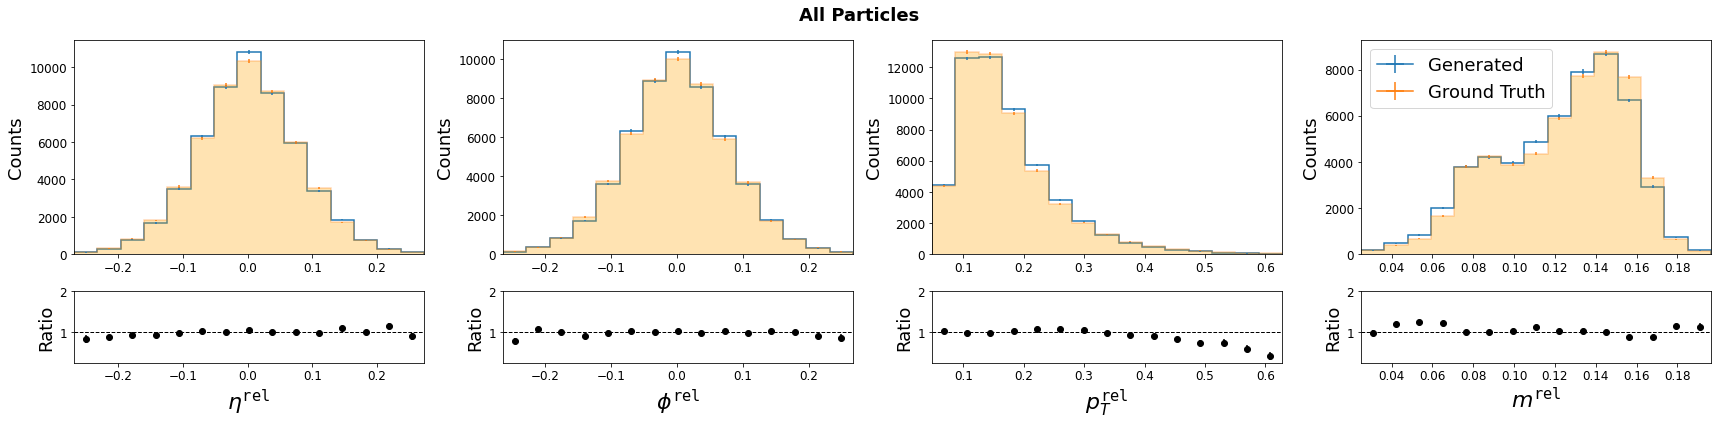

In [17]:

model.plot=plotting_paper(model=model,gen=test[:,:model.n_dim],true=true[:,:model.n_dim],config=model.config,p=config["parton"])
model.plot.plot_mass(m_test.cpu().numpy(),m_t.cpu().numpy(),save="inclusive",bins=15,quantile=True,plot_vline=False)

## Oversampling

In [18]:
weight=1000
if model.config["context_features"]==1:
    c=batch[:,-2].reshape(-1,1)
    n_true=batch[:,-1]
    batch=batch[:,:model.n_dim+1]

elif model.config["context_features"]==0:
    c=None
else:
    c=batch[:,-2:]
    n_true=batch[:,model.n_dim+1]

batch=torch.hstack((batch[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1)))                
test=torch.empty((0,91))
for i in range(weight):
    with torch.no_grad():
        if model.config["context_features"]>0:
            temptest=model.flow_test.to("cpu").sample(len(batch) if c==None else 1, c_test).to("cpu").reshape(-1,90)
            test=torch.cat((test,torch.hstack((temptest[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(temptest)).unsqueeze(1)))),axis=0)

# Reverse Standard Scaling (this has nothing to do with flows, it is a standard preprocessing step)
test=model.data_module.scaler.inverse_transform(test)

true=model.data_module.scaler.inverse_transform(batch[:,:model.n_dim+1])[:,:model.n_dim]
# We overwrite in cases where n is smaller 30 the particles after n with 0



KeyboardInterrupt: 

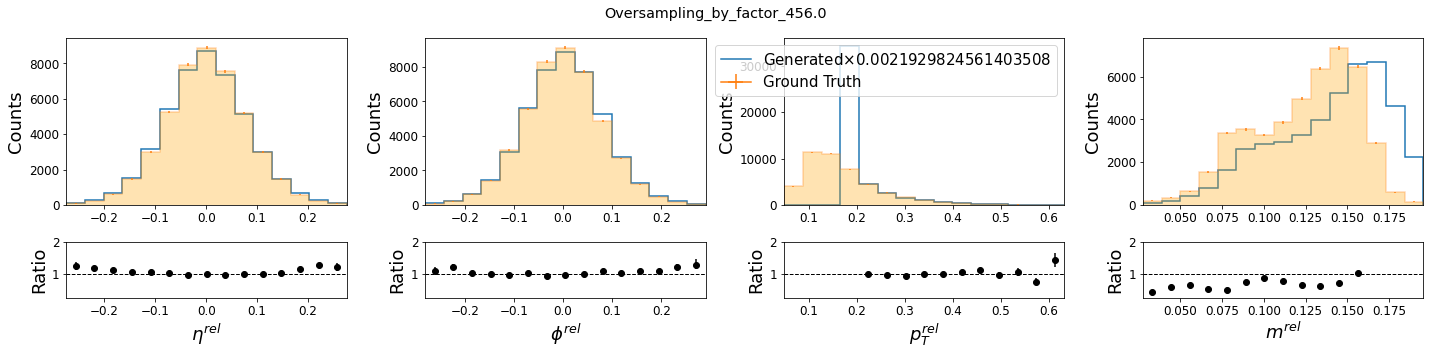

In [39]:
# if model.config["context_features"]>1:
#     for i in torch.unique(batch[:,-1]):
#         i=int(i)
#         gen[c[:,-1]==i,3*i:-1]=0
#         test[c_test[:,-1]==i,3*i:-1]=0
#This is just a nice check to see whether we overtrain 
weight=len(test)/len(true)
m_t=mass(true[:,:model.n_dim].to(model.device),model.config["canonical"]).cpu()
m_gen=mass(gen[:,:model.n_dim],model.config["canonical"]).cpu()
m_test=mass(test[:,:model.n_dim],model.config["canonical"]).cpu()
# gen=torch.column_stack((gen[:,:90],m_gen))
test=torch.column_stack((test[:,:90],m_test))       
#SET MIN PT TO 0
for i in range(30):
    i=2+3*i
    gen[gen[:,i]<0,i]=0
    test[test[:,i]<0,i]=0
    true[true[:,i]<0,i]=0
    #Some metrics we track

model.plot=plotting_paper(model=model,gen=test[:,:model.n_dim],true=true[:,:model.n_dim],config=model.config,p=config["parton"])


model.plot.oversample(m_test.cpu().numpy(),m_t.cpu().numpy(),save="Oversampling_by_factor_{}".format(weight),weight=weight,bins=15,quantile=True,plot_vline=False)
#             model.plot.plot_marginals(save=True)
#       model.plot.var_part(true=true[:,:model.n_dim],gen=test[:,:model.n_dim],true_n=n_true,gen_n=n_test,m_true=m_t,m_gen=m_test ,save=True)

        # #         model.flow.to("cuda")
        #     model.plot.plot_correlations()


## To recreate results table run below 2 cells

/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


{'network_layers': 4, 'network_nodes': 294, 'batch_size': 10000, 'coupling_layers': 10, 'lr': 0.0001052411392693, 'batchnorm': True, 'bins': 6, 'tail_bound': 8, 'limit': 150000, 'n_dim': 90, 'dropout': 0.4183396136763045, 'lr_schedule': False, 'n_sched': 1000.0, 'canonical': False, 'max_steps': 50000, 'lambda': 0.0191483740736913, 'n_mse_turnoff': 1000000, 'n_mse_delay': 5, 'name': 'g', 'disc': False, 'calc_massloss': False, 'context_features': 0, 'variable': 1.0, 'spline': True, 'parton': 'g', 'oversampling': False}
c0_g {'logprob': 0.3267814848158095, 'fpnd': 2.2713403432945256, 'mmd': 0.03616884038814566, 'cov': 0.5130000000000001, 'w1m': 0.00566062483286485, 'w1efp': 4.13426711226984e-05, 'w1p': 0.0028926077904450243, 'name': './best_model/ckpts/g_c_0.ckpt', 'w1pe': 0.0007251979303132923, 'w1me': 0.00028682300248538084, 'w1efpe': 8.545959360106385e-06}


/tmp/ipykernel_171213/598064807.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(pd.DataFrame(temp_,index=[root]))


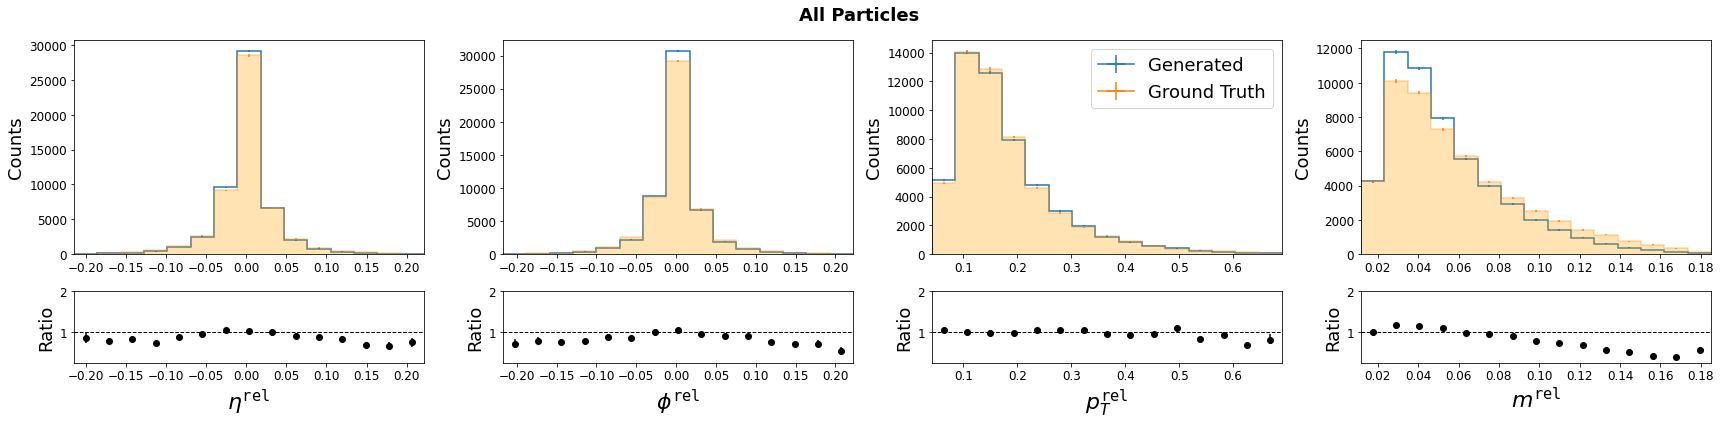

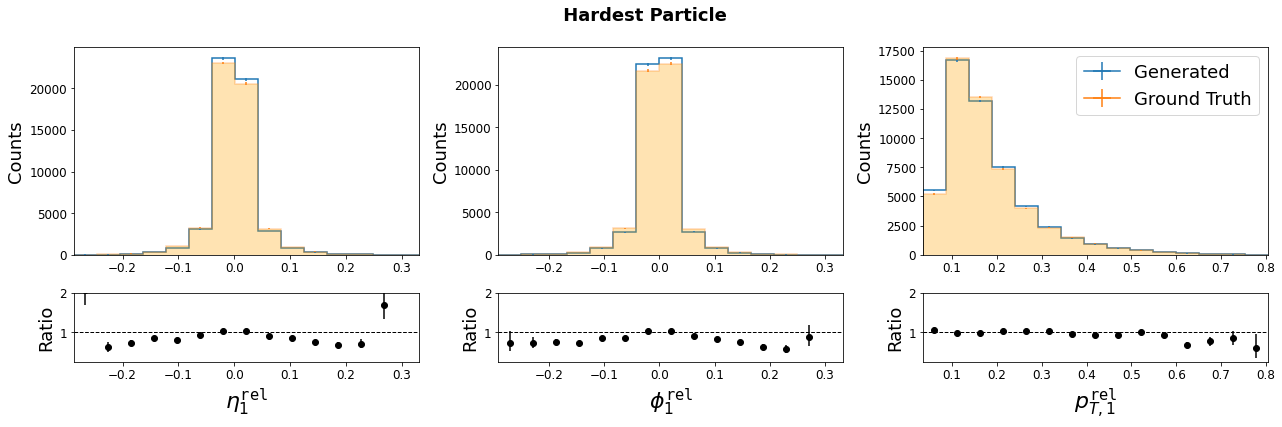

Traceback (most recent call last):
  File "/tmp/ipykernel_171213/598064807.py", line 116, in <cell line: 4>
    model.plot.plot_2d(save=None,ith=i)
AttributeError: 'plotting_paper' object has no attribute 'plot_2d'


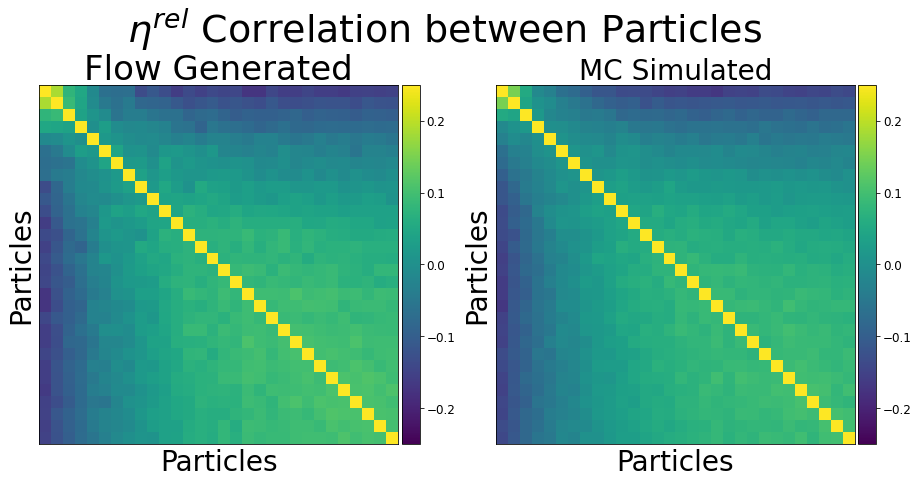

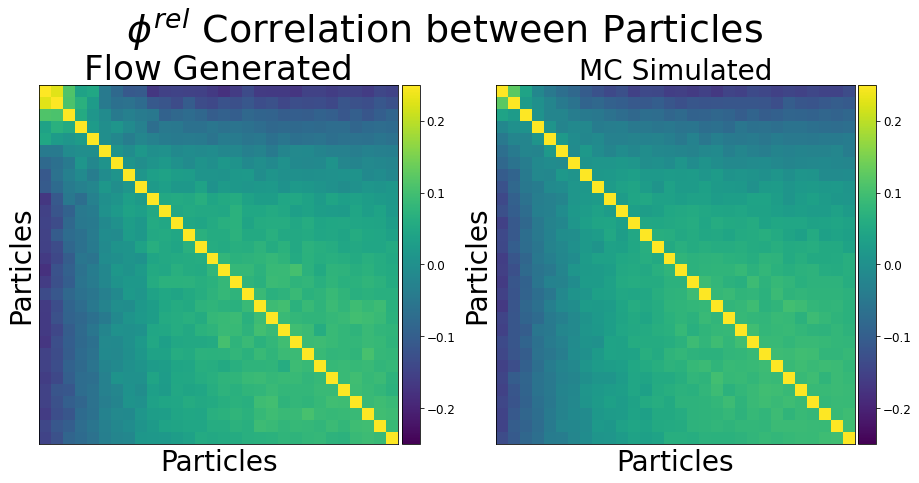

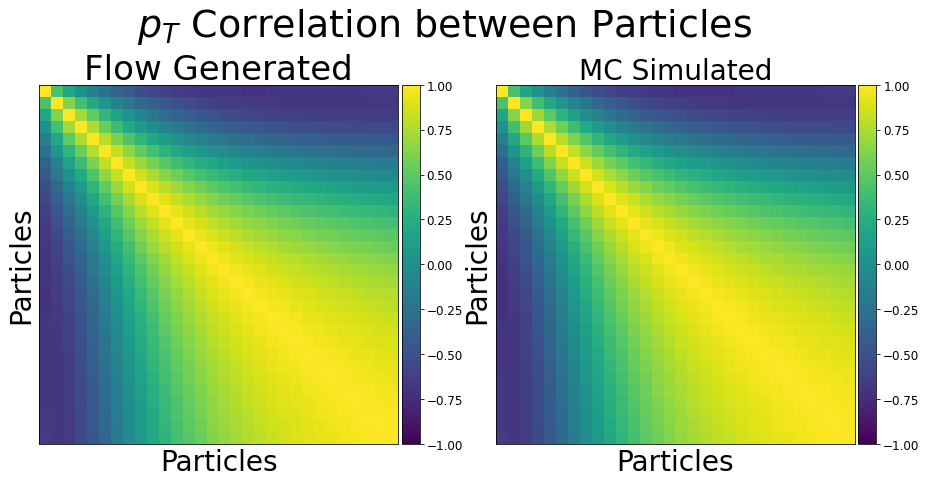

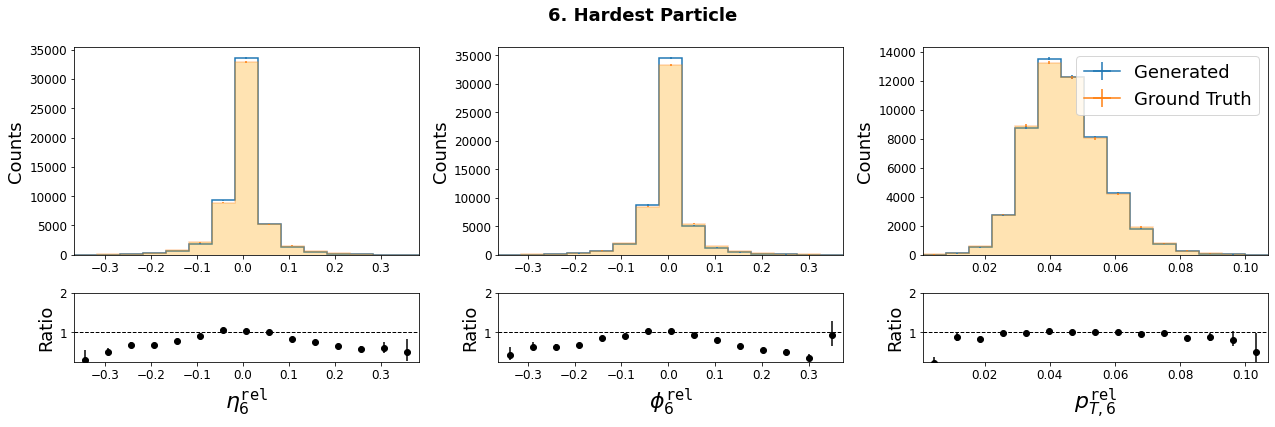

Traceback (most recent call last):
  File "/tmp/ipykernel_171213/598064807.py", line 116, in <cell line: 4>
    model.plot.plot_2d(save=None,ith=i)
AttributeError: 'plotting_paper' object has no attribute 'plot_2d'


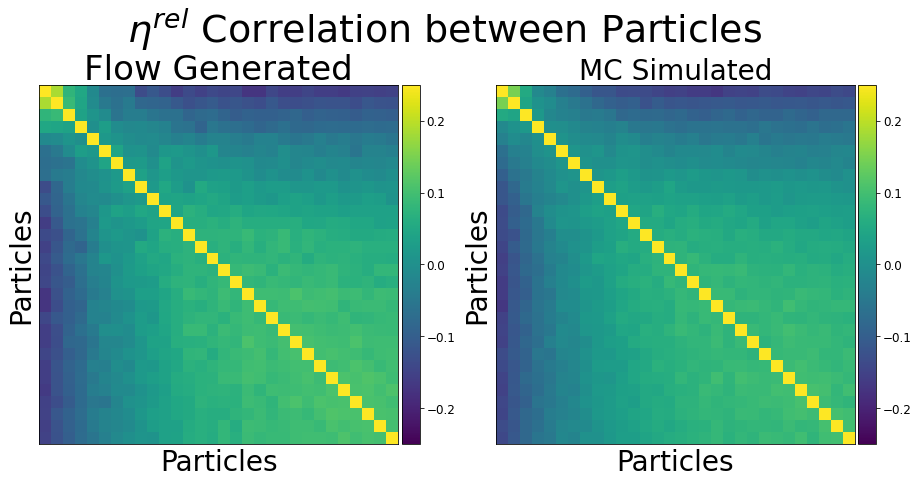

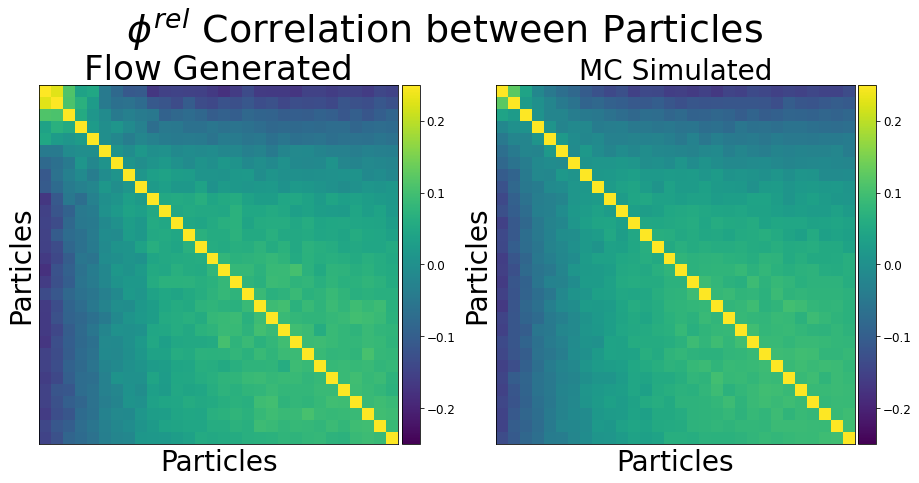

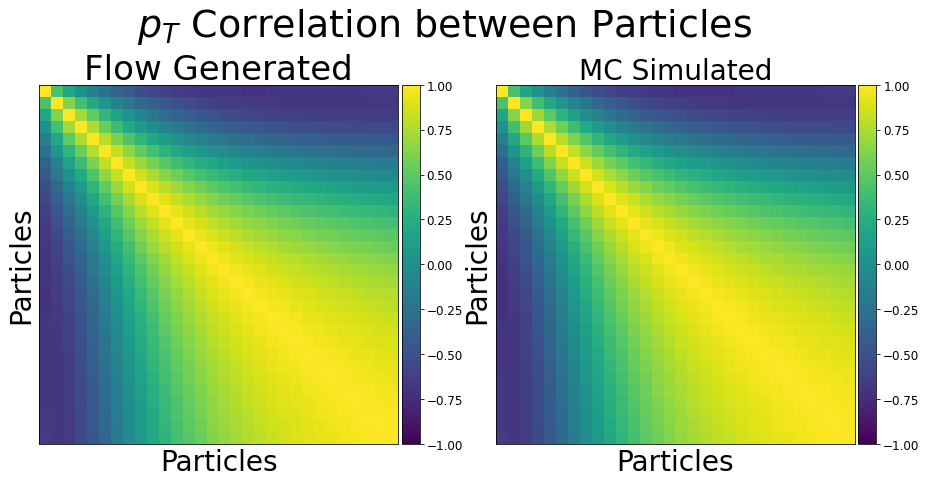

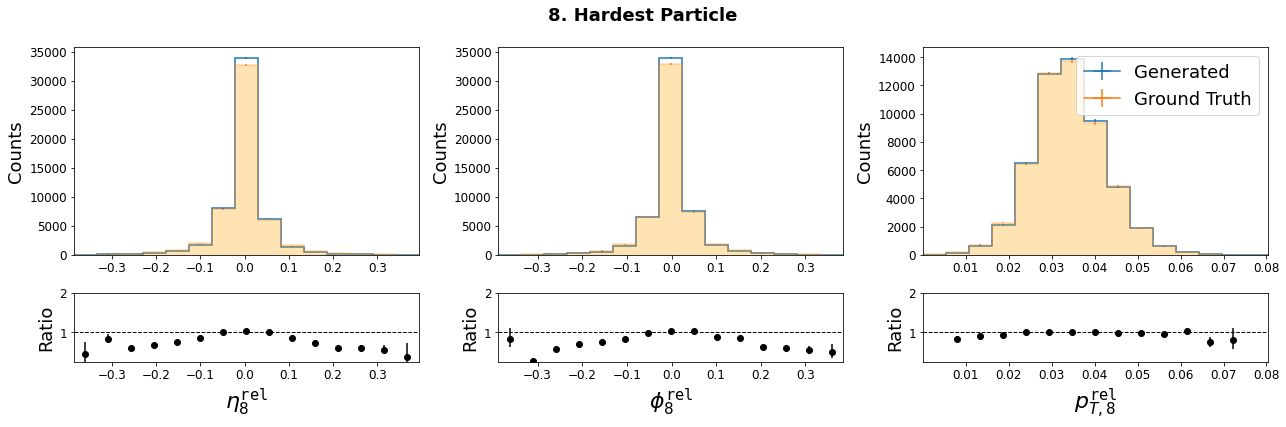

Traceback (most recent call last):
  File "/tmp/ipykernel_171213/598064807.py", line 116, in <cell line: 4>
    model.plot.plot_2d(save=None,ith=i)
AttributeError: 'plotting_paper' object has no attribute 'plot_2d'


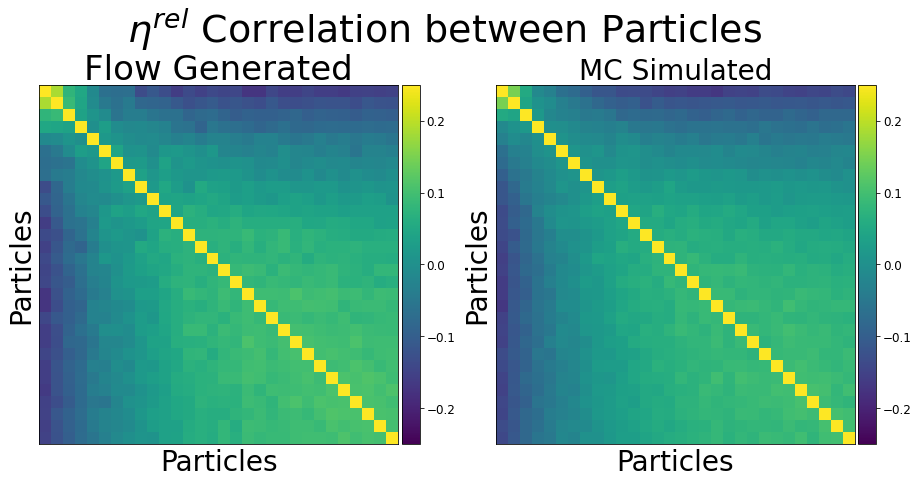

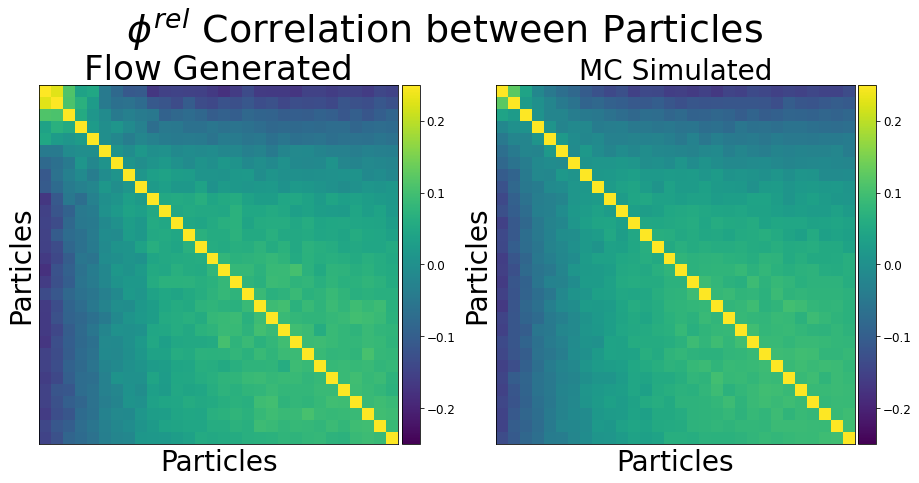

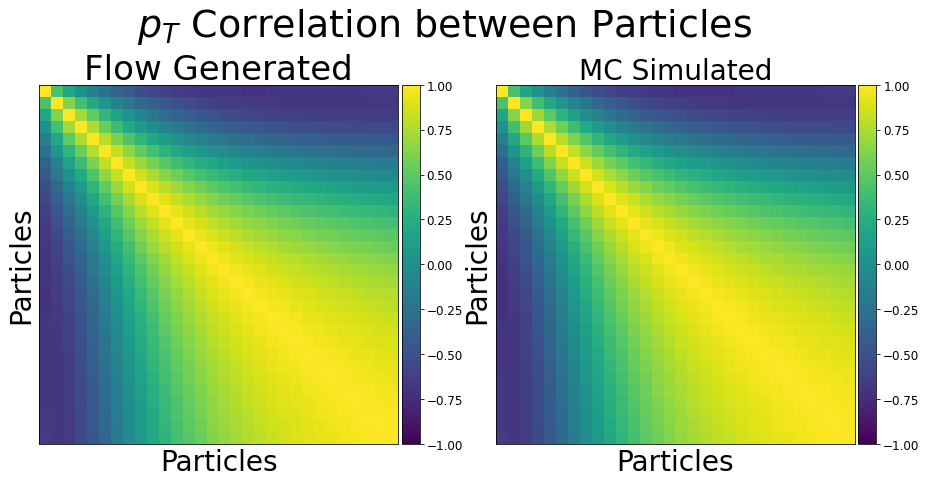

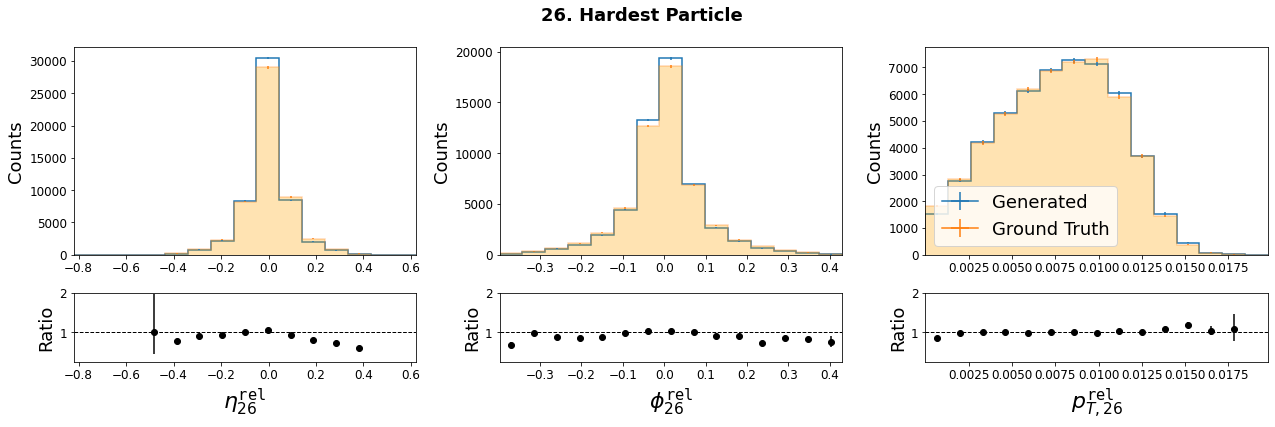

Traceback (most recent call last):
  File "/tmp/ipykernel_171213/598064807.py", line 116, in <cell line: 4>
    model.plot.plot_2d(save=None,ith=i)
AttributeError: 'plotting_paper' object has no attribute 'plot_2d'


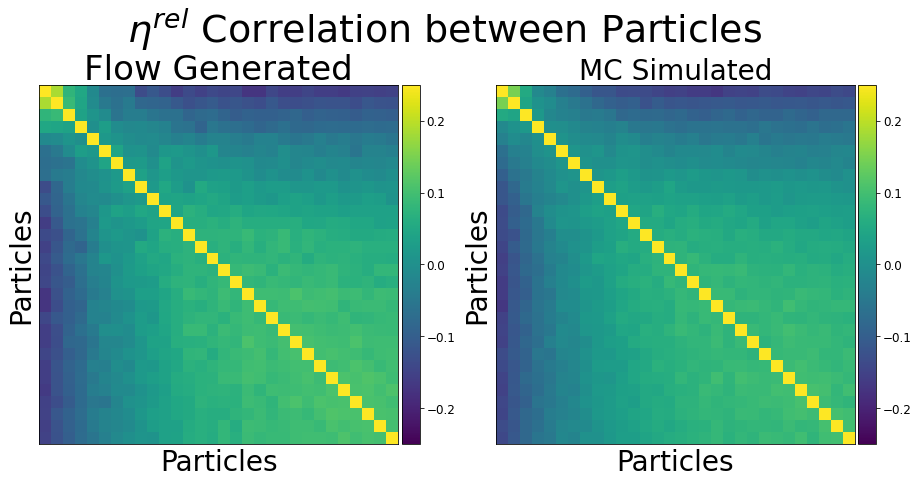

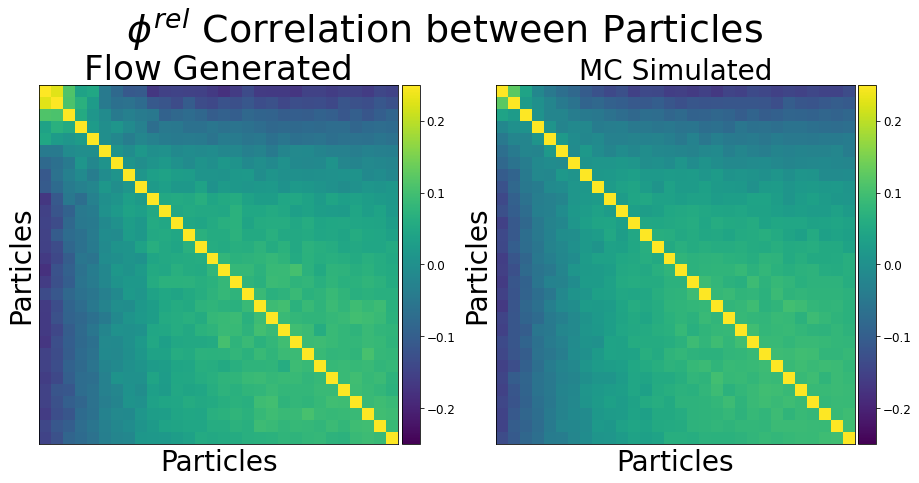

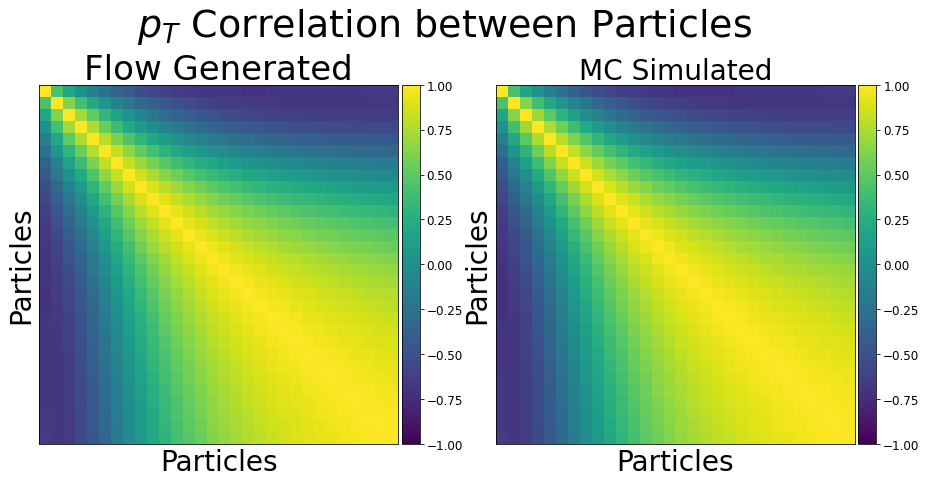

/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


{'network_layers': 5, 'network_nodes': 144, 'batch_size': 10000, 'coupling_layers': 16, 'lr': 0.0001625139195757, 'batchnorm': True, 'bins': 5, 'tail_bound': 9, 'limit': 150000, 'n_dim': 90, 'dropout': 0.0123259819793513, 'lr_schedule': False, 'n_sched': 1000.0, 'canonical': False, 'max_steps': 50000, 'lambda': 2.1150973762334067, 'n_mse_turnoff': 1000000, 'n_mse_delay': 5, 'name': 'g', 'disc': False, 'calc_massloss': True, 'context_features': 0, 'variable': 1.0, 'spline': True, 'parton': 'g', 'oversampling': False}
cc0_g {'logprob': 0.3910046047634549, 'fpnd': 1.5715218332265408, 'mmd': 0.038600246583828685, 'cov': 0.525, 'w1m': 0.003669979138057678, 'w1efp': 3.2950838332359506e-05, 'w1p': 0.0017436502813828244, 'name': './best_model/ckpts/g_cc_0.ckpt', 'w1pe': 0.00031805353428197256, 'w1me': 0.00017924821037865478, 'w1efpe': 7.002409175190579e-06}


/tmp/ipykernel_171213/598064807.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(pd.DataFrame(temp_,index=[root]))


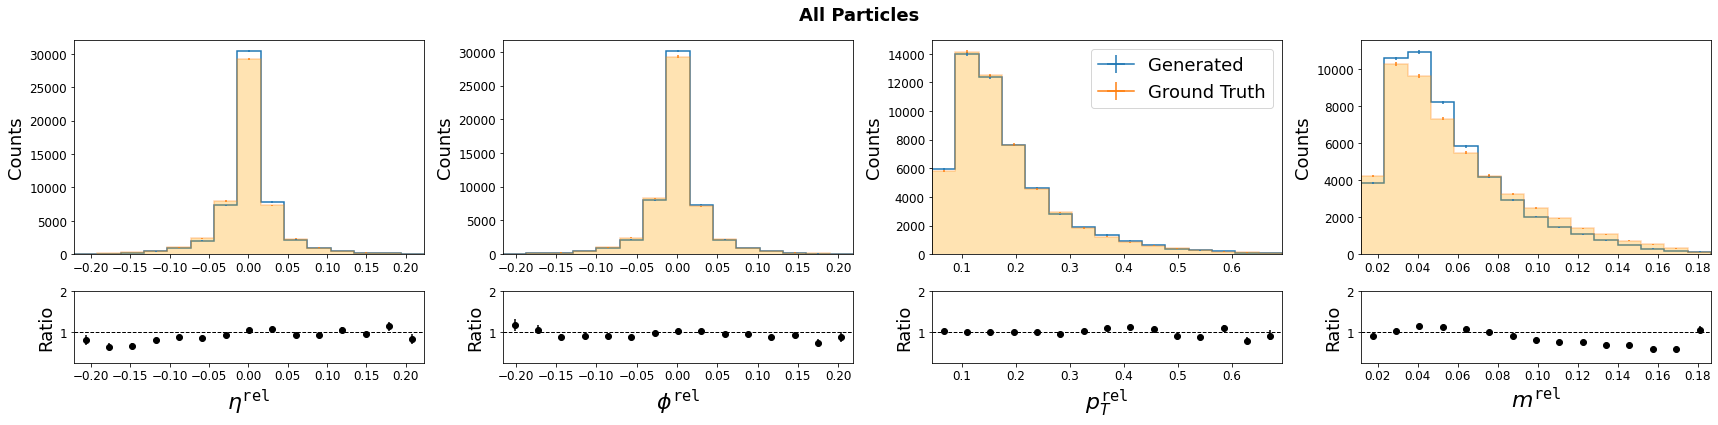

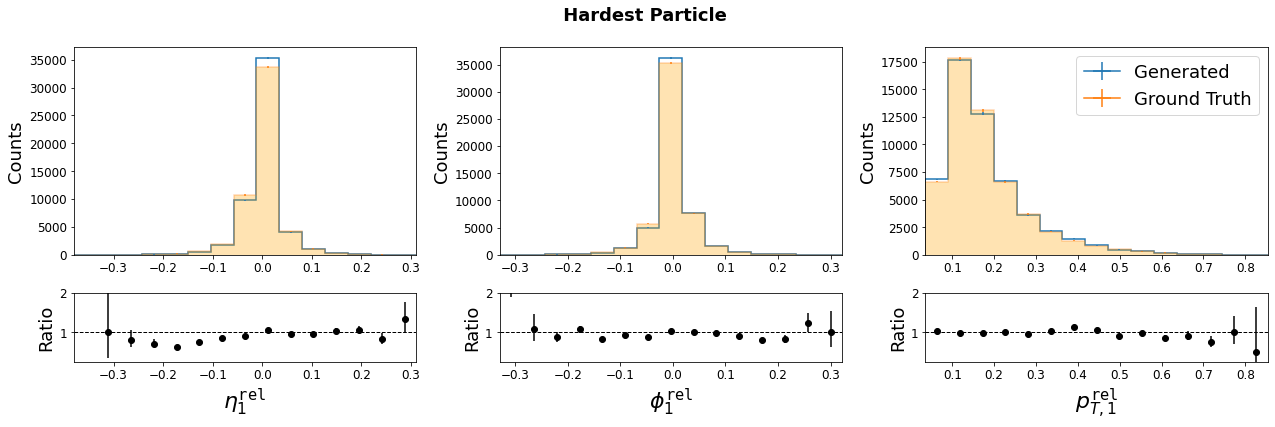

Traceback (most recent call last):
  File "/tmp/ipykernel_171213/598064807.py", line 116, in <cell line: 4>
    model.plot.plot_2d(save=None,ith=i)
AttributeError: 'plotting_paper' object has no attribute 'plot_2d'


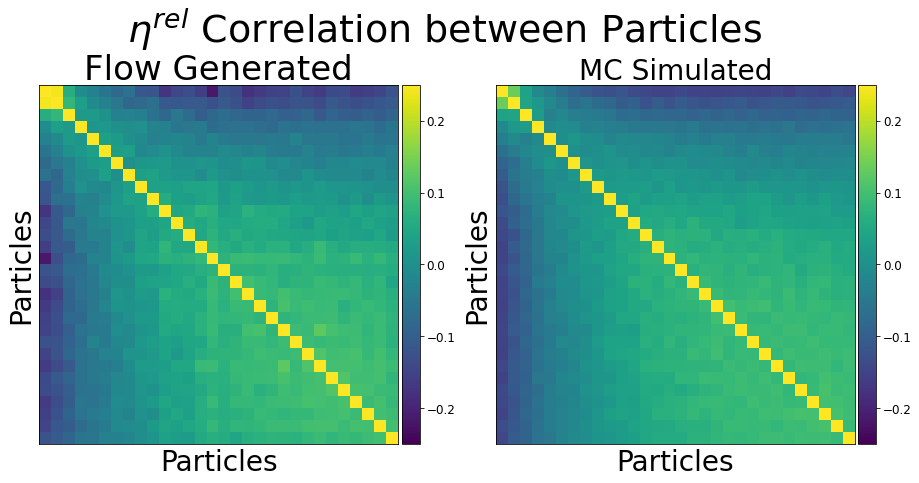

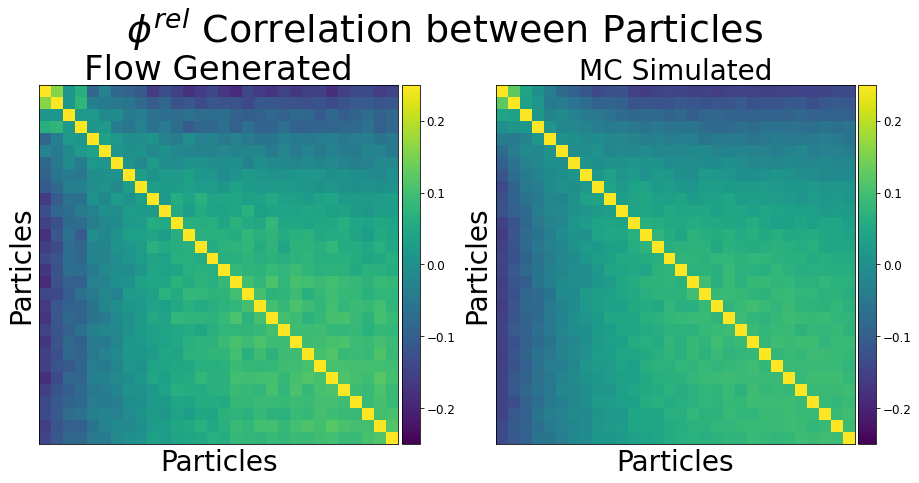

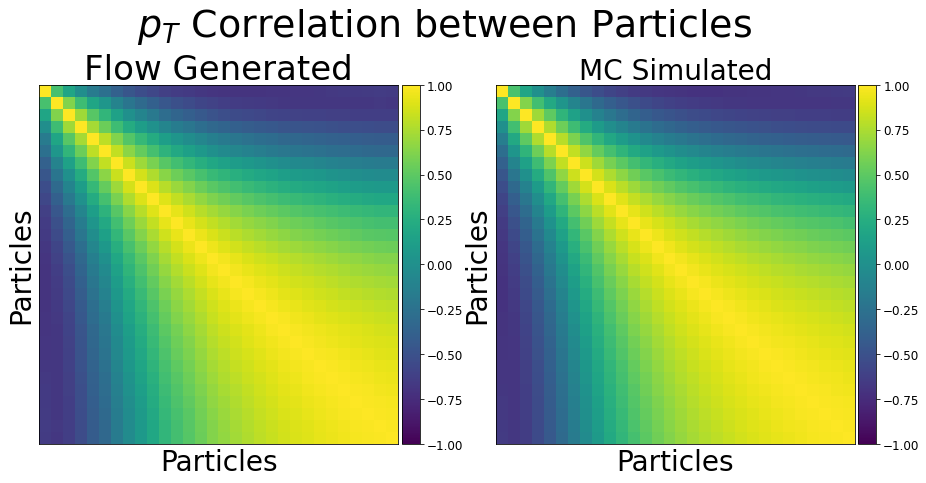

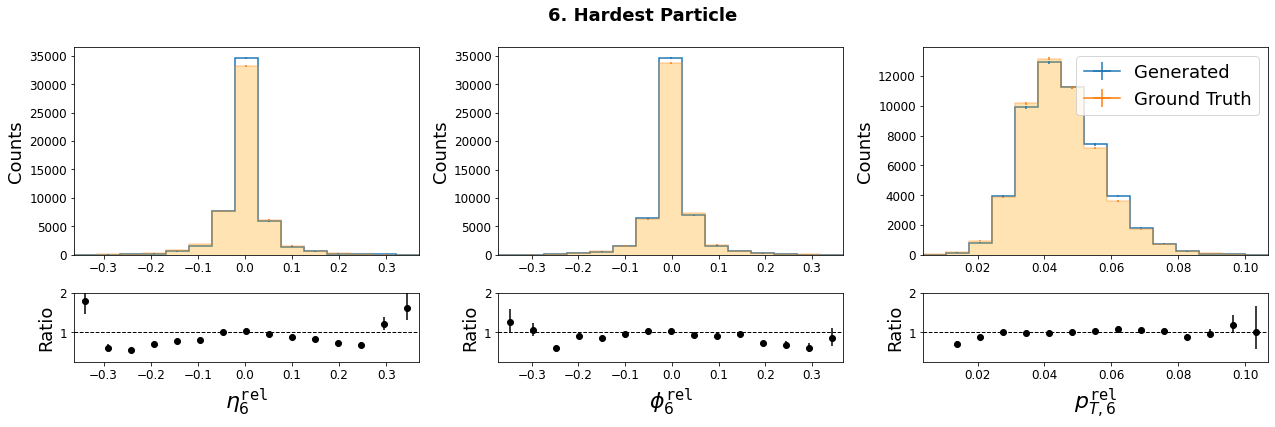

Traceback (most recent call last):
  File "/tmp/ipykernel_171213/598064807.py", line 116, in <cell line: 4>
    model.plot.plot_2d(save=None,ith=i)
AttributeError: 'plotting_paper' object has no attribute 'plot_2d'


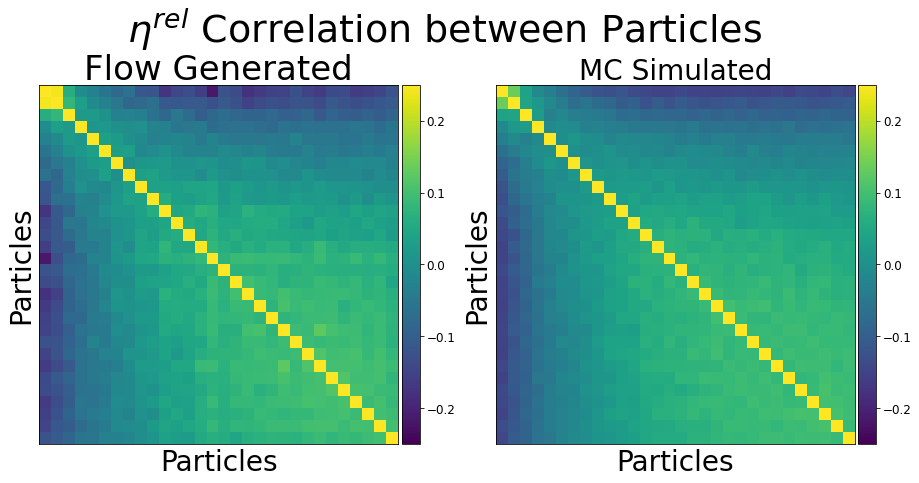

KeyboardInterrupt: 

In [22]:
q="t"
df=pd.DataFrame()
results_df=pd.DataFrame()
for q in ["g","q","t"]:
    for c in [0,1,2]:
        cname=str(c)
        for typ in ["c","cc"]:
            root="./best_model/ckpts/{}_{}_{}.ckpt".format(q,typ,cname)
            # This just sets up the dataloader, nothing particularly important. it reads in a csv, calculates mass and reads out the number particles per jet
            # And adds it to the dataset as variable. The only important thing is that we add noise to zero padded jets
            
            name=typ+str(cname)+"_"+q
            model=model.load_from_checkpoint(root)
            data_module=JetNetDataloader(model.config)
            model.load_datamodule(data_module)
            model.data_module.setup("validation")
            model.data_module.scaler.to("cpu")  
            batch=model.data_module.test_set.to("cpu")
            model.flow.eval()
            print(model.config)
            if model.config["context_features"]==1:
                c=batch[:,-2].reshape(-1,1)
                n_true=batch[:,-1]
                batch=batch[:,:model.n_dim+1]
                
            elif model.config["context_features"]==0:
                c=None
                # c_test,n_test=model.test_cond(len(batch))
                # n_true=batch[:,-1]
                # batch=batch[:,:model.n_dim+1]
            else:
                c=batch[:,-2:]
                n_true=batch[:,model.n_dim+1]
            #c=batch[:,-model.config["context_features"]:] if model.config["context_features"] else None #this is the condition
            if model.config["context_features"]>0:
                c_test,n_test=model.test_cond(len(batch)) #this is the condition in the case of testing
                c_test=c_test.reshape(-1,model.config["context_features"])
            with torch.no_grad():
                if model.config["context_features"]>0:

                    gen=model.flow_test.to("cpu").sample(len(batch) if c==None else 1,c).to("cpu")
                    test=model.flow_test.to("cpu").sample(len(batch) if c==None else 1, c_test).to("cpu").reshape(-1,90)
                    gen=torch.hstack((gen[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1))) 
                    batch=torch.hstack((batch[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1)))                
                    test=torch.hstack((test[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(test)).unsqueeze(1)))
                else:
                    gen=model.flow_test.to("cpu").sample(len(batch) if c==None else 1).to("cpu")
                    test=model.flow_test.to("cpu").sample(len(batch) if c==None else 1).to("cpu").reshape(-1,90)
                    # batch=batch[:,:model.n_dim]
                    gen=torch.hstack((gen[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1))) 
                    batch=torch.hstack((batch[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1)))                
                    test=torch.hstack((test[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(test)).unsqueeze(1)))
                # if model.config["oversampling"]:
                #     order=torch.sort(test.reshape(-1,30,3)[:,:,2],dim=1,descending=True)[1]
                #     test=torch.gather(input=test.reshape(-1,30,3),index=order.unsqueeze(-1).repeat(1,1,3),dim=1).reshape(-1,90)
                #test=test.reshape(-1,30,3)[order.repeat(1,1,3)].reshape(-1,90)
            
            # Reverse Standard Scaling (this has nothing to do with flows, it is a standard preprocessing step)
            test=model.data_module.scaler.inverse_transform(test)
            gen=model.data_module.scaler.inverse_transform(gen)
            true=model.data_module.scaler.inverse_transform(batch[:,:model.n_dim+1])[:,:model.n_dim]
            # We overwrite in cases where n is smaller 30 the particles after n with 0
            if model.config["context_features"]>1:
                for i in torch.unique(batch[:,-1]):
                    i=int(i)
                    gen[c[:,-1]==i,3*i:-1]=0
                    test[c_test[:,-1]==i,3*i:-1]=0
            #This is just a nice check to see whether we overtrain 
            logprob = -model.flow.to("cpu").log_prob(batch[:,:model.n_dim],c     ).detach().mean().numpy()/model.n_dim
            # if model.global_step > 100:
            #     if logprob > 1: ###Cut off logprob value
            #         raise ValueError('Logprob over 1')
            #calculate mass distrbutions & concat them to training sample
            m_t=mass(true[:,:model.n_dim].to(model.device),model.config["canonical"]).cpu()
            m_gen=mass(gen[:,:model.n_dim],model.config["canonical"]).cpu()
            m_test=mass(test[:,:model.n_dim],model.config["canonical"]).cpu()
            # gen=torch.column_stack((gen[:,:90],m_gen))
            test=torch.column_stack((test[:,:90],m_test))       
            # Again checking for overtraining
            mse=FF.mse_loss(m_t,m_gen).detach()
            
                
            for i in range(30):
                i=2+3*i
                gen[gen[:,i]<0,i]=0
                test[test[:,i]<0,i]=0
                true[true[:,i]<0,i]=0
                #Some metrics we track
            cov,mmd=cov_mmd(true[:,:model.n_dim].reshape(-1,model.n_dim//3,3),test[:,:model.n_dim].reshape(-1,model.n_dim//3,3),use_tqdm=False)
            try:
                fpndv=fpnd(test[:,:model.n_dim].reshape(-1,model.n_dim//3,3).numpy(),use_tqdm=False,jet_type=model.config["parton"])
            except:
                fpndv=1000
            model.metrics["val_fpnd"].append(fpndv)
            model.metrics["val_logprob"].append(logprob)
            model.metrics["val_mmd"].append(mmd)
            model.metrics["val_cov"].append(cov)
            model.metrics["val_w1p"].append(w1p(test[:,:model.n_dim].reshape(-1,model.n_dim//3,3),true[:,:model.n_dim].reshape(-1,model.n_dim//3,3)))
            model.metrics["val_w1m"].append(w1m(test[:,:model.n_dim].reshape(-1,model.n_dim//3,3),true[:,:model.n_dim].reshape(-1,model.n_dim//3,3)))
            model.metrics["val_w1efp"].append(w1efp(test[:,:model.n_dim].reshape(-1,model.n_dim//3,3),true[:,:model.n_dim].reshape(-1,model.n_dim//3,3)))
            
            
            temp_={"logprob":logprob,"fpnd":fpndv,"mmd":mmd,"cov":cov,"w1m":model.metrics["val_w1m"][-1][0],"w1efp":model.metrics["val_w1efp"][-1][0],"w1p":model.metrics["val_w1p"][-1][0],"name":root,"w1pe":model.metrics["val_w1p"][-1][1],"w1me":model.metrics["val_w1m"][-1][1],"w1efpe":model.metrics["val_w1efp"][-1][1]}
            print(name,temp_)
            results_df=results_df.append(pd.DataFrame(temp_,index=[root]))
            # This part here adds the plots to tensorboard
            
            model.plot=plotting_paper(model=model,gen=gen[:,:model.n_dim],true=true[:,:model.n_dim],config=model.config,p=config["parton"])
            model.plot.plot_mass(m_test.cpu().numpy(),m_t.cpu().numpy(),save=None,bins=15,leg=-2)
            for i in [0,5,7,25]:

                model.plot.plot_marginals(save=None,ith=i)

                try:
                    
                    model.plot.plot_2d(save=None,ith=i)
                    model.plot.var_part(true=true[:,:model.n_dim],gen=test[:,:model.n_dim],true_n=n_true,gen_n=n_test,m_true=m_t,m_gen=m_test ,save=None)
                except Exception as e:
                    traceback.print_exc()
                    
                model.plot.plot_correlations()
            
                    

In [29]:
from tkinter import W


def format_mean_sd(mean, sd):
    """round mean and standard deviation to most significant digit of sd and apply latex formatting"""
    decimals = -int(np.floor(np.log10(sd)))
    decimals -= int((sd * 10 ** decimals) >= 9.5)

    if decimals < 0:
        ten_to = 10 ** (-decimals)
        if mean > ten_to:
            mean = ten_to * (mean // ten_to)
        else:
            mean_ten_to = 10 ** np.floor(np.log10(mean))
            mean = mean_ten_to * (mean // mean_ten_to)
        sd = ten_to * (sd // ten_to)
        decimals = 0

    if mean >= 1e3 and sd >= 1e3:
        mean = np.round(mean * 1e-3)
        sd = np.round(sd * 1e-3)
        return f"${mean:.{decimals}f}$k $\\pm {sd:.{decimals}f}$k"
    else:
        return f"${mean:.{decimals}f} \\pm {sd:.{decimals}f}$"

# print_table.index=["t"]#"q"
print_table=results_df.copy()
print_table.columns=["logprob","fpnd","mmd","cov","w1m","w1efp","w1p","name","pmm","pmp","pme"]
cols=["w1m","w1p","w1efp","pmm","pmp","pme","cov","fpndv","mmd"]
print_table["model"]=print_table["name"].str.split("nf/").str[1].str.split("/lig").str[0].str.replace("_","").str.replace("top","")
print_table=print_table.drop("logprob",1).set_index("model",drop=False).drop("name",1)
print_table=print_table[["w1m","w1p","w1efp","fpnd","cov","mmd","pmm","pmp","pme","model"]]

print_table.loc[:,"w1m"]*=1000
print_table.loc[:,"w1p"]*=1000
print_table.loc[:,"w1efp"]*=100000
print_table.loc[:,"pmm"]*=1000
print_table.loc[:,"pmp"]*=1000
print_table.loc[:,"pme"]*=100000
print_table.loc["MP-MP-g",:]=np.array([0.7,0.9,0.7,0.12,0.56,0.037,0.2,0.3,0.7,"MP-MP"])

print_table.loc["MPLFC-MP-g",:]=np.array([0.69,1.8,0.9,0.2,0.54,0.037,.07,.3,.2,"MP_LFC-MP"])
print_table.loc["MP-MP-q",:]=np.array([0.6,4.9,0.7,0.35,0.50,0.026,.2,.5,.4,"MP-MP"])

print_table.loc["MPLFC-MP-q",:]=np.array([0.7,2.6,0.9,0.08,0.52,0.037,.2,.4,.9,"MP_LFC-MP"])


print_table.loc["MP-MP-t",:]=np.array([0.6,2.3,2,0.37,0.57,0.071,.2,.3,1,"MP-MP"])
print_table.loc["MPLFC-MP-t",:]=np.array([0.9,2.2,2,0.93,0.56,0.073,.3,.7,1,"MP_LFC-MP"])
print_table.loc[:,"w1m"]=print_table.apply(lambda x:format_mean_sd(float(x["w1m"]),float(x["pmm"])),axis=1)
print_table.loc[:,"w1efp"]=print_table.apply(lambda x:format_mean_sd(float(x["w1efp"]),float(x["pme"])),axis=1)
print_table.loc[:,"w1p"]=print_table.apply(lambda x:format_mean_sd(float(x["w1p"]),float(x["pmp"])),axis=1)


print_table.loc[:,"cov"]=print_table.loc[:,"cov"].astype(float).map('{:.2f}'.format)
print_table.loc[:,"fpnd"]=print_table.loc[:,"fpnd"].astype(float).map('{:.2f}'.format)
print_table.loc[:,"mmd"]=print_table.loc[:,"mmd"].astype(float).map('{:.3f}'.format)

print_table.loc[:,"pmm"]=print_table.loc[:,"pmm"].astype(float).map('{:,.2f}'.format)

print_table.loc[:,"pmp"]=print_table.loc[:,"pmp"].astype(float).map('{:,.2f}'.format)

print_table.loc[:,"pme"]=print_table.loc[:,"pme"].astype(float).map('{:,.2f}'.format)
print_table.loc[:,"parton"]=print_table.index.str[-1]
# print_table.loc[:,"val_w1m"]="$"+print_table["val_w1m"].map(str)+"\pm"+print_table["pmm"].map(str)+"$"
# print_table.loc[:,"val_w1p"]="$"+print_table["val_w1p"].map(str)+"\pm"+print_table["pmp"].map(str)+"$"
# print_table.loc[:,"val_w1efp"]="$"+print_table["val_w1efp"].map(str)+"\pm"+print_table["pme"].map(str)+"$"
print_table.loc[:,"cov"]="$"+print_table["cov"].map(str)+"$"
print_table.loc[:,"fpnd"]="$"+print_table["fpnd"].map(str)+"$"
print_table.loc[:,"mmd"]="$"+print_table["mmd"].map(str)+"$"
print(print_table["model"].str.replace("cc0","VNF"))
print_table.loc[:,"model"]=print_table["model"].str.replace("cc0","VNF").str.replace("c0","VNF").str.replace("cc","CCNF").str.replace("c","CNF").str.replace("1","\ (m)").str.replace("2","\ (m,n)").str.replace("q","").str.replace("g","").str.replace("t","")

index=["MP-MP-g","MPLFC-MP-g","c0g","c1g","c2g","cc1g","cc2g","MP-MP-q","MPLFC-MP-q","cc0q","c1q","c2q","cc1q","cc2q","MP-MP-t","MPLFC-MP-t","c0t","c1t","c2t","cc1t","cc2t"]
print_table=print_table.loc[index,:]

final_table=pd.DataFrame()
tex=""
for p in ["g","q","t"]:
    temp=print_table[print_table["parton"]==p]

    for col in print_table.drop("model",axis=1).columns:
        
        if col not in ["w1m","w1p","w1efp","fpnd","cov","mmd" ]:
            continue
        
        temp_index=temp[col].str.replace("$","").str.split("\\").str[0].astype(float)
        mins=temp_index==temp_index.min() if col!="cov" else temp_index==temp_index.max()
        temp.loc[mins,col]="$\mathbf{"+temp.loc[mins,col].astype(str).str.replace("$","")+"}$"
    temp=temp[["model","w1m","w1p","w1efp","fpnd","cov","mmd"]]
    temp.columns=["model","$W_1^M (\times 10^{-3})$","$W_1^P (\times 10^{-3})$","$W_1^{EFP}(\times 10^{-5})$","FPND",r"COV $\uparrow$","MMD"]
    text=temp.to_latex(index=False,escape=False)
    parton="Gluon" if p=="g" else "Light Quark" if p=="q" else "Top Quark"
    tex+="\multirow{7}{*}{"+parton+"} & "+text.split("MMD \\\\")[1].split("\\bottomrule")[0].replace("\\\\","\\\\&").replace("\\midrule","").replace("MP_LFC","MP\_LFC").replace("  ","")[:-2]+"\cline{1-8}" 
    tex+="\n"
print(tex)


    #     final_table=final_table.append(temp)

# print(final_table.to_latex(index=False,escape=False))


/tmp/ipykernel_35103/3419053601.py:31: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  print_table=print_table.drop("logprob",1).set_index("model",drop=False).drop("name",1)
/tmp/ipykernel_35103/3419053601.py:31: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  print_table=print_table.drop("logprob",1).set_index("model",drop=False).drop("name",1)
/tmp/ipykernel_35103/3419053601.py:87: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp_index=temp[col].str.replace("$","").str.split("\\").str[0].astype(float)
/tmp/ipykernel_35103/3419053601.py:89: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single charac

model
c0g                 c0g
cc0g               VNFg
c1g                 c1g
cc1g               cc1g
c2g                 c2g
cc2g               cc2g
cc0q               VNFq
c1q                 c1q
cc1q               cc1q
c2q                 c2q
cc2q               cc2q
c0t                 c0t
c1t                 c1t
cc1t               cc1t
c2t                 c2t
cc2t               cc2t
MP-MP-g           MP-MP
MPLFC-MP-g    MP_LFC-MP
MP-MP-q           MP-MP
MPLFC-MP-q    MP_LFC-MP
MP-MP-t           MP-MP
MPLFC-MP-t    MP_LFC-MP
Name: model, dtype: object


/tmp/ipykernel_35103/3419053601.py:92: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  text=temp.to_latex(index=False,escape=False)
/tmp/ipykernel_35103/3419053601.py:87: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp_index=temp[col].str.replace("$","").str.split("\\").str[0].astype(float)
/tmp/ipykernel_35103/3419053601.py:89: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp.loc[mins,col]="$\mathbf{"+temp.loc[mins,

\multirow{7}{*}{Gluon} & 
MP-MP &$0.7 \pm 0.2$ &$0.9 \pm 0.3$ &$\mathbf{0.7 \pm 0.7}$ & $\mathbf{0.12}$ & $\mathbf{0.56}$ &$0.037$ \\&

MP\_LFC-MP &$0.69 \pm 0.07$ &$1.8 \pm 0.3$ & $0.9 \pm 0.2$ &$0.20$ &$0.54$ &$0.037$ \\&
VNF &$5.5 \pm 0.7$ &$2.9 \pm 0.7$ & $4.4 \pm 0.8$ &$2.32$ &$0.54$ &$0.035$ \\&
 CNF\ (m) &$0.9 \pm 0.1$ &$0.6 \pm 0.3$ & $0.9 \pm 0.5$ &$0.68$ &$0.54$ &$0.036$ \\&
 CNF\ (m,n) &$0.9 \pm 0.3$ &$0.7 \pm 0.2$ & $0.9 \pm 0.5$ &$0.70$ &$0.55$ & $\mathbf{0.034}$ \\&
CCNF\ (m) &$0.9 \pm 0.2$ & $\mathbf{0.5 \pm 0.2}$ & $1.1 \pm 0.5$ &$1.10$ &$0.55$ &$0.036$ \\&
CCNF\ (m,n) & $\mathbf{0.6 \pm 0.5}$ &$0.8 \pm 0.1$ & $0.9 \pm 0.8$ &$0.72$ & $\mathbf{0.56}$ &$0.035$ \\\cline{1-8}
\multirow{7}{*}{Light Quark} & 
MP-MP & $\mathbf{0.6 \pm 0.2}$ &$4.9 \pm 0.5$ &$\mathbf{0.7 \pm 0.4}$ &$0.35$ &$0.50$ &$0.026$ \\&

MP\_LFC-MP &$0.7 \pm 0.2$ &$2.6 \pm 0.4$ & $0.9 \pm 0.9$ & $\mathbf{0.08}$ &$0.52$ &$0.037$ \\&
VNF &$3.5 \pm 0.3$ &$2.3 \pm 0.4$ & $3 \pm 1$ &$2.10$ &$0.54$ &$0.025$ \\&


/tmp/ipykernel_35103/3419053601.py:92: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  text=temp.to_latex(index=False,escape=False)
